## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

### A note on variation of output

Note as always that due to the use of random numbers, some of the results here may differ from those in the book (since I re-ran everything to prepare this notebook), and will probably be different yet again if you run this notebook.

### Chapter 18: Autoencoders - Notebook 3: MNIST 2

In [1]:
import inspect
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
import os
import sys

os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['KERAS_BACKEND'] = 'torch'
import torch
import torchvision
import torchvision.transforms as transforms
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Input, MaxPooling2D, UpSampling2D
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import h5py
from pathlib import Path

from keras import backend as keras_backend, backend
from keras.src.legacy.backend import cast_to_floatx
from keras.src.utils import to_categorical

keras_backend.set_image_data_format('channels_last')

In [2]:
# Choose GPU if available
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu")

print("Using device:", device)

Using device: cuda


In [3]:
# Make a File_Helper for saving and loading files.

save_files = False

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [4]:
random_seed = 42
np.random.seed(random_seed)

# load the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# cast the sample data to the current Keras floating-point type
X_train = cast_to_floatx(X_train)
X_test = cast_to_floatx(X_test)

# reshape to 2D grid, one line per image
X_train = X_train.reshape(X_train.shape[0], number_of_pixels)
X_test = X_test.reshape(X_test.shape[0], number_of_pixels)

# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0

# reshape sample data to 4D tensor using channels_last convention
X_train = X_train.reshape(X_train.shape[0], image_height, image_width, 1)
X_test = X_test.reshape(X_test.shape[0], image_height, image_width, 1)

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = to_categorical(y_train, number_of_classes)
y_test = to_categorical(y_test, number_of_classes)

In [5]:
CAE_encoder_input = Input(shape=(28,28, 1))
CAE_encoder_conv_1 = Conv2D(16, (3, 3), activation='relu', padding='same')
CAE_encoder_pool_1 = MaxPooling2D((2,2), padding='same')
CAE_encoder_conv_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
CAE_encoder_pool_2 = MaxPooling2D((2,2), padding='same')
CAE_encoder_output = Conv2D(3, (3, 3), activation='relu', padding='same')

CAE_decoder_up_1 = UpSampling2D((2,2))
CAE_decoder_conv_1 = Conv2D(16, (3, 3), activation='relu', padding='same')
CAE_decoder_up_2 = UpSampling2D((2,2))
CAE_decoder_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')

CAE_encoder_step_1 = CAE_encoder_conv_1(CAE_encoder_input)
CAE_encoder_step_2 = CAE_encoder_pool_1(CAE_encoder_step_1)
CAE_encoder_step_3 = CAE_encoder_conv_2(CAE_encoder_step_2)
CAE_encoder_step_4 = CAE_encoder_pool_2(CAE_encoder_step_3)
CAE_encoder_step_5 = CAE_encoder_output(CAE_encoder_step_4)

CAE_decoder_step_1 = CAE_decoder_up_1(CAE_encoder_step_5)
CAE_decoder_step_2 = CAE_decoder_conv_1(CAE_decoder_step_1)
CAE_decoder_step_3 = CAE_decoder_up_2(CAE_decoder_step_2)
CAE_decoder_step_4 = CAE_decoder_output(CAE_decoder_step_3)


Conv_AE = Model(CAE_encoder_input, CAE_decoder_step_4)
Conv_AE.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Conv_AE_encoder_only_model = Model(CAE_encoder_input, CAE_encoder_step_5)
                    
Conv_AE_decoder_only_input = Input(shape=(7, 7, 3))
Conv_AE_decoder_only_step_1 = CAE_decoder_up_1(Conv_AE_decoder_only_input)
Conv_AE_decoder_only_step_2 = CAE_decoder_conv_1(Conv_AE_decoder_only_step_1)
Conv_AE_decoder_only_step_3 = CAE_decoder_up_2(Conv_AE_decoder_only_step_2)
Conv_AE_decoder_only_step_4 = CAE_decoder_output(Conv_AE_decoder_only_step_3)
                      
Conv_AE_decoder_only_model = Model(Conv_AE_decoder_only_input, Conv_AE_decoder_only_step_4)

In [6]:
weights_filename = "NB3-Conv-AE-weights"
np.random.seed(42)
print(backend.backend())
if not file_helper.load_model_weights(Conv_AE, weights_filename):
    Conv_AE.fit(X_train, X_train,
               epochs=50, batch_size=128, shuffle=True,
               verbose=2,
               validation_data=(X_test, X_test))
    file_helper.save_model_weights(Conv_AE, weights_filename)

torch
Epoch 1/50
469/469 - 16s - 35ms/step - accuracy: 0.8079 - loss: 0.1801 - val_accuracy: 0.8125 - val_loss: 0.0934
Epoch 2/50
469/469 - 11s - 23ms/step - accuracy: 0.8138 - loss: 0.0887 - val_accuracy: 0.8132 - val_loss: 0.0844
Epoch 3/50
469/469 - 12s - 25ms/step - accuracy: 0.8143 - loss: 0.0837 - val_accuracy: 0.8135 - val_loss: 0.0815
Epoch 4/50
469/469 - 13s - 28ms/step - accuracy: 0.8145 - loss: 0.0814 - val_accuracy: 0.8136 - val_loss: 0.0796
Epoch 5/50
469/469 - 12s - 26ms/step - accuracy: 0.8147 - loss: 0.0798 - val_accuracy: 0.8138 - val_loss: 0.0782
Epoch 6/50
469/469 - 12s - 25ms/step - accuracy: 0.8148 - loss: 0.0784 - val_accuracy: 0.8139 - val_loss: 0.0769
Epoch 7/50
469/469 - 12s - 25ms/step - accuracy: 0.8149 - loss: 0.0770 - val_accuracy: 0.8140 - val_loss: 0.0757
Epoch 8/50
469/469 - 12s - 25ms/step - accuracy: 0.8150 - loss: 0.0760 - val_accuracy: 0.8141 - val_loss: 0.0748
Epoch 9/50
469/469 - 12s - 25ms/step - accuracy: 0.8150 - loss: 0.0753 - val_accuracy: 0.8

In [7]:
def draw_predictions_set(predictions, filename=None):
    plt.figure(figsize=(8, 4))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.subplot(2, 5, i+6)
        plt.imshow(predictions[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    file_helper.save_figure(filename+'-predictions')
    plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


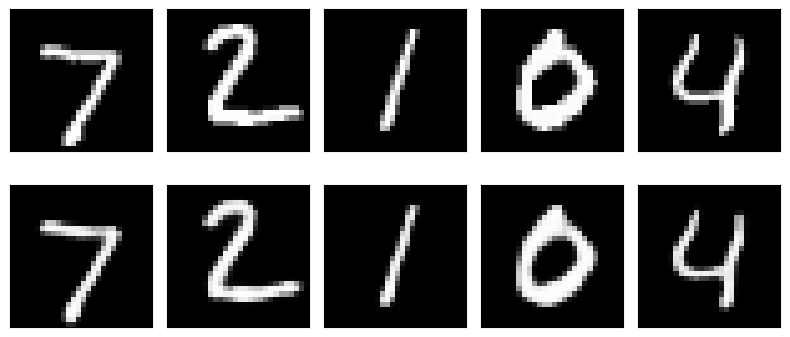

In [8]:
Conv_predictions = Conv_AE.predict(X_test)
draw_predictions_set(Conv_predictions, 'NB3-ConvAE-predictions')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


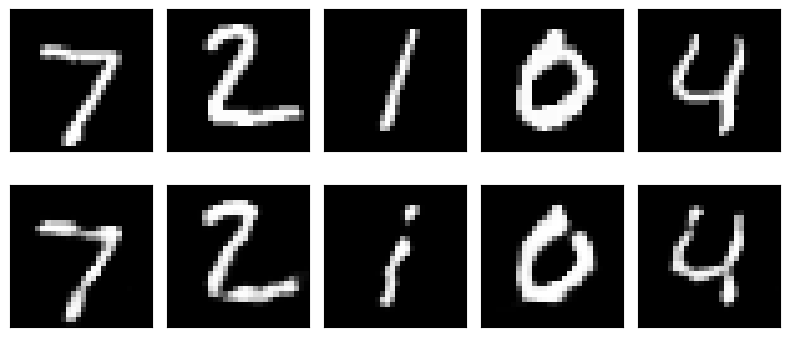

In [9]:
Conv_latents = Conv_AE_encoder_only_model.predict(X_test)
conv_noisy_in = Conv_latents.copy()[0:5]
noise = 1
for i in range(5):
    for v2 in range(7):
        for v3 in range(7):
            conv_noisy_in[i,v2,v3] += np.random.uniform(low=-noise, high=noise)
conv_noisy_predictions = Conv_AE_decoder_only_model.predict(conv_noisy_in)
conv_noisy_predictions.shape
draw_predictions_set(conv_noisy_predictions, 'NB3-ConvAE-noise-add-1')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


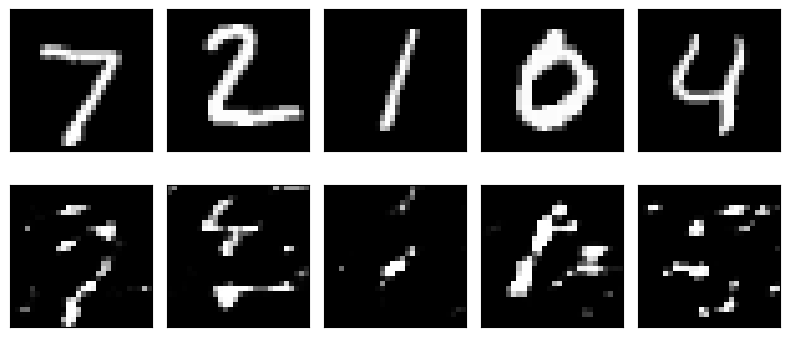

In [10]:
Conv_latents = Conv_AE_encoder_only_model.predict(X_test)
conv_noisy_in = Conv_latents.copy()[0:5]
noise = 5
for i in range(5):
    for v2 in range(7):
        for v3 in range(7):
            conv_noisy_in[i,v2,v3] += np.random.uniform(low=-noise, high=noise)
conv_noisy_predictions = Conv_AE_decoder_only_model.predict(conv_noisy_in)
conv_noisy_predictions.shape
draw_predictions_set(conv_noisy_predictions, 'NB3-ConvAE-noise-add-5')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


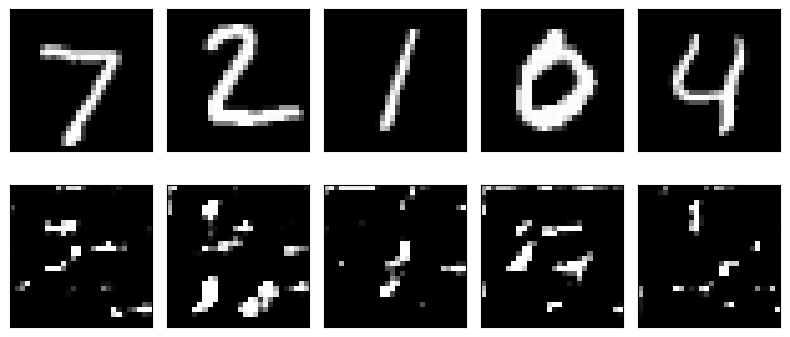

In [11]:
Conv_latents = Conv_AE_encoder_only_model.predict(X_test)
conv_noisy_in = Conv_latents.copy()[0:5]
noise = 10
for i in range(5):
    for v2 in range(7):
        for v3 in range(7):
            conv_noisy_in[i,v2,v3] += np.random.uniform(low=-noise, high=noise)
conv_noisy_predictions = Conv_AE_decoder_only_model.predict(conv_noisy_in)
conv_noisy_predictions.shape
draw_predictions_set(conv_noisy_predictions, 'NB3-ConvAE-noise-add-10')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


<Figure size 640x480 with 0 Axes>

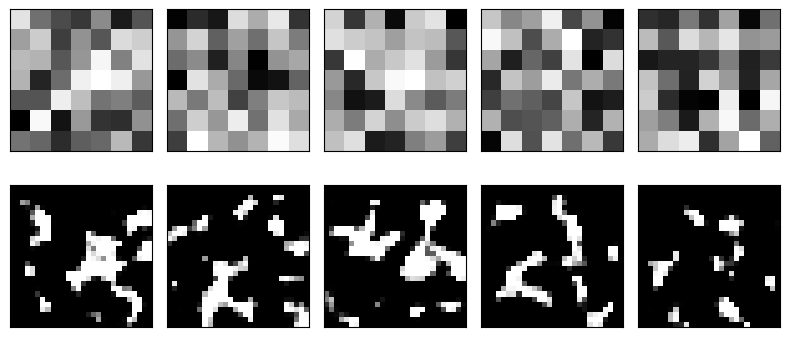

In [12]:
conv_noisy_in = np.random.uniform(low=0, high=16, size=(5*7*7*3))
conv_noisy_in = np.reshape(conv_noisy_in, (5,7,7,3))
conv_noisy_predictions = Conv_AE_decoder_only_model.predict(conv_noisy_in)

plt.clf()
plt.figure(figsize=(8, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(conv_noisy_in[i,:,:,0].reshape(7, 7), cmap="gray", interpolation='nearest')
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.subplot(2, 5, i+6)
    plt.imshow(conv_noisy_predictions[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
file_helper.save_figure('NB3-ConvAE-all-noise-predictions')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


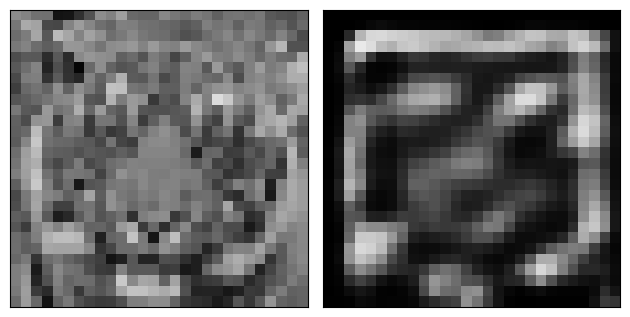

In [13]:
from PIL import Image
filepath = file_helper.get_input_file_path("tiger-gray-28-28.png")
im = Image.open(filepath) #Can be many different formats.
pix = im.load()
tiger = np.zeros((1,784))
for y in range(28):
    for x in range(28):
        tiger[0,(y*28)+x] = pix[x,y][0]/255.
tiger = np.reshape(tiger, (1, 28, 28, 1))
        
predicted_tiger = Conv_AE.predict(tiger)

plt.subplot(1, 2, 1)
plt.imshow(np.reshape(tiger, (28, 28)), vmin=0, vmax=1, cmap="gray")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.subplot(1, 2, 2)
plt.imshow(np.reshape(predicted_tiger, (28, 28)), vmin=0, vmax=1, cmap="gray")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
file_helper.save_figure("NB3-ConvAE-tiger-pair")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


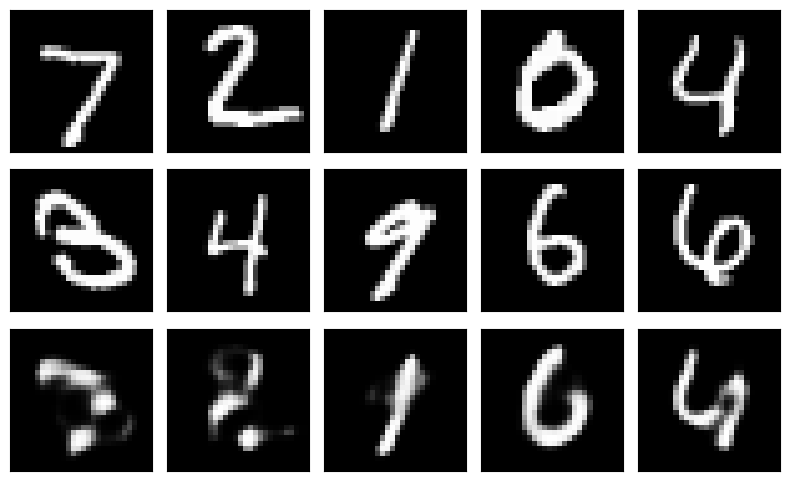

In [14]:
# blend latents for two test images and decompress
encoder_predictions = np.array(Conv_AE_encoder_only_model.predict(X_test))
np.random.seed(random_seed)

plt.figure(figsize=(8, 5))
offset = 18
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_test[i].reshape(28, 28), cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.subplot(3, 5, i+6)
    plt.imshow(X_test[i+offset].reshape(28, 28), cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.subplot(3, 5, i+11)
    latent0 = np.reshape(encoder_predictions[i], (3*7*7,))
    latent1 = np.reshape(encoder_predictions[i+offset], (3*7*7,))
    latent_mix = [(latent0[i]+latent1[i])/2. for i in range(len(latent0))]
    latent_mix = np.reshape(latent_mix, (1,7,7,3))
    decoder_prediction = Conv_AE_decoder_only_model.predict(latent_mix)
    plt.imshow(decoder_prediction.reshape(28, 28), cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
file_helper.save_figure("NB3-ConvAE-blend-grid")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


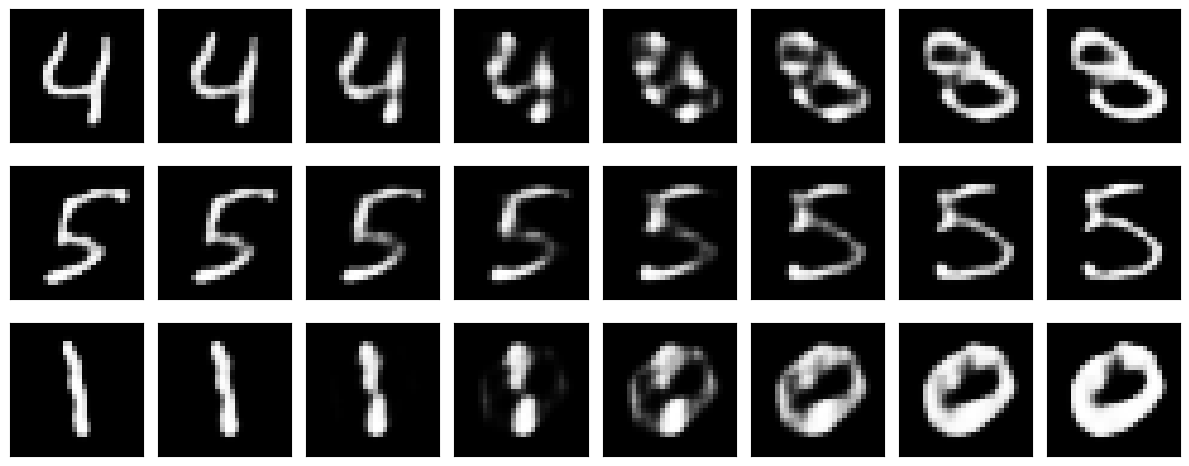

In [15]:
# blend latents for two test images and decompress
encoder_predictions = np.array(Conv_AE_encoder_only_model.predict(X_test))
np.random.seed(random_seed)

steps = 8
plt.figure(figsize=(12, 5))
latent0_list = [ encoder_predictions[4], encoder_predictions[23], encoder_predictions[29]]
latent1_list = [ encoder_predictions[18], encoder_predictions[15], encoder_predictions[25]]

for r in range(3):
    latent0 = np.reshape(latent0_list[r], (3*7*7,))
    latent1 = np.reshape(latent1_list[r], (3*7*7,))
    for i in range(steps): 
        plt.subplot(3, steps, (steps*r)+(i+1))
        alpha = i/(steps-1.0)
        latent_mix = [latent0[i]+(alpha*(latent1[i]-latent0[i])) for i in range(len(latent0))]
        latent_mix = np.reshape(latent_mix, (1, 7, 7, 3))
        decoder_prediction = Conv_AE_decoder_only_model.predict(latent_mix)
        plt.imshow(decoder_prediction.reshape(28, 28), cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.tight_layout()
file_helper.save_figure("NB3-ConvAE-blend-linear")
plt.show()